## The Darcy's equation

We consider the following Darcy flows in a 2D area filled with porous materials. The governing PDE is 
$$
-\nabla( K(x,y) \nabla P(x,y)) = f(x,y), \quad x\in\Omega
$$  
where $K$ is the permeability field, $P$ is the pressure, and $f$ is a source term which can be either a constant or a space-dependent function.
### (1.1) Neural Operator learning problem

The first example of Darcy flow is defined in a rectangular domain $\Omega=[0,1]^2$ with zero Dirichlet boundary condition. We are interested in learning the mapping from the permeability field $K(x,y)$ to the pressure field $P(x,y)$, i.e.,
$$
\mathcal{G}: K(x,y) \rightarrow P(x,y)
$$

## (2) The Physics-informed DeepOnet

In [1]:
import sys 
sys.path.append("../..") 
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
#
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
# 设置随机数种子
random_seed = 1234
setup_seed(random_seed)
device = 'cuda:0'
dtype = torch.float32
problem_name = 'Darcy_Flow_pwc2d'
tag = 'fdm'
######################################
# Load training data
######################################
data_train = h5py.File('../../Problems/DarcyFlow_2d/pwc_train.mat', 'r')
data_test = h5py.File('../../Problems/DarcyFlow_2d/pwc_test_in.mat', 'r')
print(data_train.keys())
print(data_test.keys())
res = 29
######################################
from Utils.utils import *
n_train, n_test = 1000, 200
def get_data(data, ndata, dtype, n0=0):
    a = np2tensor(np.array(data["coeff"][...,n0:n0+ndata]).T, dtype)
    a[a==1.] = 10.; a[a==0.] = 5.;
    u = np2tensor(np.array(data["sol_fem"][...,n0:n0+ndata]).T, dtype)
    #
    try:
        X, Y = np.array(data['X_sol']).T, np.array(data['Y_sol']).T
        mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
        gridx = mesh.reshape(-1, 2)
    except:
        X, Y = np.array(data['X']).T, np.array(data['Y']).T
        mesh = np2tensor(np.vstack([X.ravel(), Y.ravel()]).T, dtype)
        gridx = mesh.reshape(-1, 2)
    #
    x = gridx.repeat((ndata, 1, 1))
    a = a.reshape(ndata, -1, 1)
    u = u.reshape(ndata, -1, 1)
    
    return a, u, x, gridx
#
a_train, u_train, x_train, grid_train = get_data(data_train, n_train, dtype)
a_test, u_test, x_test, grid_test = get_data(data_test, n_test, dtype)
#
print('The shape of x_train:', x_train.shape)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of grid_train:', grid_train.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape)
print('The shape of grid_test:', grid_test.shape)
######################################
# Generate mesh grids for calculating gradients
######################################
from Utils.GenPoints import Point2D
pointGen = Point2D(x_lb=[0., 0.], x_ub=[1.,1.], dataType=dtype, random_seed=random_seed)
#
N_mesh = 29
x_mesh = pointGen.inner_point(N_mesh, method='mesh')
print('x_mesh shape:', x_mesh.shape)

<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol_fdm', 'sol_fem']>
The shape of x_train: torch.Size([1000, 841, 2])
The shape of a_train: torch.Size([1000, 841, 1])
The shape of u_train: torch.Size([1000, 841, 1])
The shape of grid_train: torch.Size([841, 2])
The shape of x_test: torch.Size([200, 841, 2])
The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1])
The shape of grid_test: torch.Size([841, 2])
x_mesh shape: torch.Size([841, 2])


### (3.2) Define the loss class and train the model 

In [2]:
###############################
# Define Loss Class
###############################
from Utils.Grad import *
import torch.nn as nn
from torch.autograd import grad, Variable

########################################
class fun_a(object):

    def __init__(self, res):
        super(fun_a, self).__init__()
        self.res = res
        self.delta = 1./(res-1)

    def __call__(self, x, a):
        a = a.squeeze(-1)
        x_loc = torch.floor(x[...,0] / self.delta + 0.5).int()
        y_loc = torch.floor(x[...,1] / self.delta + 0.5).int()
        loc = y_loc * self.res + x_loc
        #
        img = a[torch.arange(a.size(0)).unsqueeze(1), loc]
        
        return img.unsqueeze(-1)

###############################
class mollifer(object):

    def __inint__(self):
        super(mollifer, self).__init_()
        
    def __call__(self, u, x):
        xx, yy = x[...,0:1], x[...,1:2]
        u = u * torch.sin(np.pi * xx)*torch.sin(np.pi * yy) 

        return u
        
################################
class LossClass(object):

    def __init__(self, solver):
        super(LossClass, self).__init__()
        self.solver = solver
        self.dtype = solver.dtype
        self.device = solver.device
        self.fun_a = fun_a(res=res)
        self.model_u = solver.model_dict['u']
        self.mollifer = mollifer()
        #
        self.deltax = 1/(N_mesh-1)
        self.deltay = 1/(N_mesh-1)

    def Loss_pde(self, a_batch, w_pde):
        '''Define the PDE loss
        '''
        n_batch = a_batch.shape[0]
        if w_pde>0.:
            a = self.fun_a(x_mesh, a_batch)
            x = Variable(x_mesh.repeat(n_batch, 1, 1).to(self.device), requires_grad=True)
            u = self.model_u(x, a_batch)
            u = self.mollifer(u, x).reshape(-1, N_mesh, N_mesh, 1)
            a = a.reshape(-1, N_mesh, N_mesh, 1)
            dudx, dudy = FDM_2d(u, self.deltax, self.deltay) 
            adux = a[:,1:-1,1:-1,0:1] * dudx 
            aduy = a[:,1:-1,1:-1,0:1] * dudy 
            dauxdx, _ = FDM_2d(adux, self.deltax, self.deltay) 
            _, dauydy = FDM_2d(aduy, self.deltax, self.deltay) 
            #############################################
            left = (- (dauxdx + dauydy)).reshape(n_batch, -1)
            right = 10. * torch.ones_like(left)

            return self.solver.getLoss(left, right)
        else:
            return torch.tensor(0.)

    def Loss_data(self, x, a, u, w_data):
        return torch.tensor(0.)

    def Error(self, x, a, u):
        u_pred = self.model_u(x, a)
        u_pred = self.mollifer(u_pred, x)
            
        return self.solver.getError(u_pred, u)

######################################
# Steups of the model
######################################
from Solvers.PIDeepONet import PIDeepONet
solver = PIDeepONet.Solver(device=device, dtype=dtype)
netType = 'DeepONetBatch'

####################################### The BranchNet
from Networks.CNNet import CNNet2d
class BranchNet(nn.Module):
    def __init__(self, conv_arch:list, fc_arch:list, 
                 nx_size:int, ny_size:int, dtype=None):
        super(BranchNet, self).__init__()
        self.nx_size, self.ny_size = nx_size, ny_size
        self.conv = CNNet2d(conv_arch=conv_arch, fc_arch=fc_arch,
                            activation_conv='SiLU', activation_fc='SiLU', 
                            kernel_size=(3,3), stride=2, dtype=dtype)
        
    def forward(self, x):
        x = x.reshape(-1, self.ny_size, self.nx_size).unsqueeze(1)
        x = self.conv(x)
        
        return x
#
conv_arch = [1, 64, 64, 64]
fc_arch = [64*2*2, 128, 128, 128]
branchNet = BranchNet(conv_arch, fc_arch, nx_size=res, ny_size=res, dtype=dtype)

###################################### The u model (DeepONet )
layers_branch, activation_branch = [branchNet, fc_arch[-1]], 'SiLU'
layers_trunk, activation_trunk = [2, 128, 128, 128, 128], 'ReLU'
model_u = solver.getModel(layers_branch, layers_trunk, activation_branch, activation_trunk, 
                          multi_ouput_strategy=None, num_output=1, netType=netType)
##################
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

190,337 training parameters.


### (2.3) training and make prediction

#### (2.3.1) train the model

In [3]:
model_dict = {'u':model_u}
solver.train_setup(model_dict, lr=1e-3, optimizer='Adam', scheduler_type='StepLR',
                   gamma=0.6, step_size=200)
solver.train(LossClass, a_train, u_train, x_train, a_test, u_test, x_test, 
             w_data=0., w_pde=1., batch_size=50, epochs=1000, epoch_show=50,
             **{'save_path':f'saved_models/PI{netType}_{tag}/'})

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]/home/yaohua/anaconda3/envs/dnn-python309/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  5%|████                                                                            | 51/1000 [00:06<01:42,  9.27it/s]

Epoch:50 Time:6.1025, loss:108.9863, loss_pde:108.9863, loss_data:0.0000
                l2_test:0.3167, lr:0.001


 10%|███████▉                                                                       | 101/1000 [00:11<01:37,  9.19it/s]

Epoch:100 Time:11.6509, loss:101.6544, loss_pde:101.6544, loss_data:0.0000
                l2_test:0.1898, lr:0.001


 15%|███████████▉                                                                   | 151/1000 [00:17<01:33,  9.09it/s]

Epoch:150 Time:17.1154, loss:99.5117, loss_pde:99.5117, loss_data:0.0000
                l2_test:0.2158, lr:0.001


 20%|███████████████▉                                                               | 201/1000 [00:22<01:29,  8.97it/s]

Epoch:200 Time:22.6500, loss:98.1501, loss_pde:98.1501, loss_data:0.0000
                l2_test:0.2632, lr:0.0006


 25%|███████████████████▊                                                           | 251/1000 [00:28<01:23,  8.98it/s]

Epoch:250 Time:28.2183, loss:93.5378, loss_pde:93.5378, loss_data:0.0000
                l2_test:0.2329, lr:0.0006


 30%|███████████████████████▊                                                       | 302/1000 [00:33<01:07, 10.37it/s]

Epoch:300 Time:33.5966, loss:92.5792, loss_pde:92.5792, loss_data:0.0000
                l2_test:0.2021, lr:0.0006


 35%|███████████████████████████▋                                                   | 351/1000 [00:38<01:12,  9.00it/s]

Epoch:350 Time:38.7026, loss:91.3784, loss_pde:91.3784, loss_data:0.0000
                l2_test:0.1797, lr:0.0006


 40%|███████████████████████████████▋                                               | 401/1000 [00:44<01:06,  8.98it/s]

Epoch:400 Time:44.3009, loss:91.3127, loss_pde:91.3127, loss_data:0.0000
                l2_test:0.2077, lr:0.00035999999999999997


 45%|███████████████████████████████████▋                                           | 451/1000 [00:49<01:01,  8.96it/s]

Epoch:450 Time:49.8731, loss:88.2956, loss_pde:88.2956, loss_data:0.0000
                l2_test:0.1794, lr:0.00035999999999999997


 50%|███████████████████████████████████████▋                                       | 502/1000 [00:55<00:48, 10.31it/s]

Epoch:500 Time:54.9200, loss:88.0554, loss_pde:88.0554, loss_data:0.0000
                l2_test:0.1838, lr:0.00035999999999999997


 55%|███████████████████████████████████████████▌                                   | 552/1000 [00:59<00:43, 10.29it/s]

Epoch:550 Time:59.7781, loss:87.7138, loss_pde:87.7138, loss_data:0.0000
                l2_test:0.1616, lr:0.00035999999999999997


 60%|███████████████████████████████████████████████▍                               | 601/1000 [01:05<00:45,  8.82it/s]

Epoch:600 Time:65.1634, loss:87.9567, loss_pde:87.9567, loss_data:0.0000
                l2_test:0.1366, lr:0.00021599999999999996


 65%|███████████████████████████████████████████████████▍                           | 651/1000 [01:10<00:39,  8.85it/s]

Epoch:650 Time:70.7970, loss:85.8082, loss_pde:85.8082, loss_data:0.0000
                l2_test:0.1681, lr:0.00021599999999999996


 70%|███████████████████████████████████████████████████████▍                       | 701/1000 [01:16<00:33,  8.82it/s]

Epoch:700 Time:76.4445, loss:85.7144, loss_pde:85.7144, loss_data:0.0000
                l2_test:0.1662, lr:0.00021599999999999996


 75%|███████████████████████████████████████████████████████████▎                   | 751/1000 [01:22<00:28,  8.82it/s]

Epoch:750 Time:82.1100, loss:85.6308, loss_pde:85.6308, loss_data:0.0000
                l2_test:0.1690, lr:0.00021599999999999996


 80%|███████████████████████████████████████████████████████████████▎               | 801/1000 [01:27<00:22,  8.77it/s]

Epoch:800 Time:87.8086, loss:85.7097, loss_pde:85.7097, loss_data:0.0000
                l2_test:0.1717, lr:0.00012959999999999998


 85%|███████████████████████████████████████████████████████████████████▎           | 852/1000 [01:33<00:14, 10.11it/s]

Epoch:850 Time:93.3035, loss:84.9707, loss_pde:84.9707, loss_data:0.0000
                l2_test:0.1709, lr:0.00012959999999999998


 90%|███████████████████████████████████████████████████████████████████████▏       | 901/1000 [01:38<00:09, 10.15it/s]

Epoch:900 Time:98.2509, loss:84.8994, loss_pde:84.8994, loss_data:0.0000
                l2_test:0.1509, lr:0.00012959999999999998


 95%|███████████████████████████████████████████████████████████████████████████▏   | 951/1000 [01:43<00:05,  8.72it/s]

Epoch:950 Time:103.4970, loss:84.7587, loss_pde:84.7587, loss_data:0.0000
                l2_test:0.1686, lr:0.00012959999999999998


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:49<00:00,  9.16it/s]

Epoch:1000 Time:109.2295, loss:84.5628, loss_pde:84.5628, loss_data:0.0000
                l2_test:0.1651, lr:7.775999999999999e-05
The total training time is 109.2372


### (3.3) load saved model and make prediction

The shape of a_test: torch.Size([200, 841, 1])
The shape of u_test: torch.Size([200, 841, 1]) u_pred shape torch.Size([200, 841, 1])
The test loss (avg): tensor(0.2658)
The test l2 error (avg): tensor(0.1651)


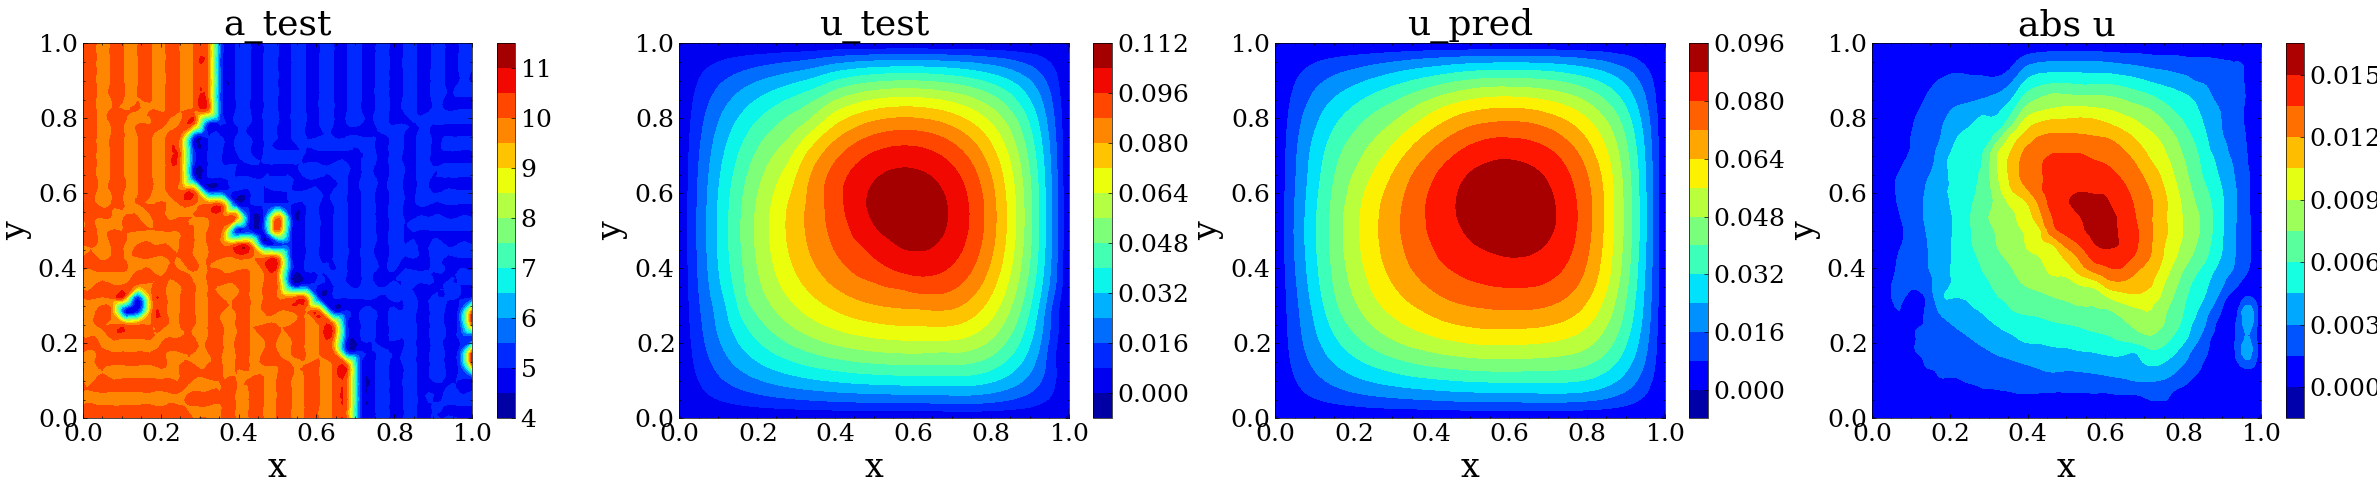

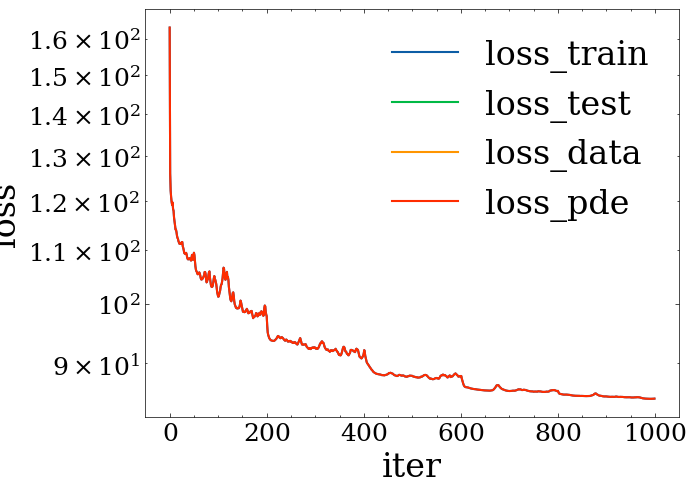

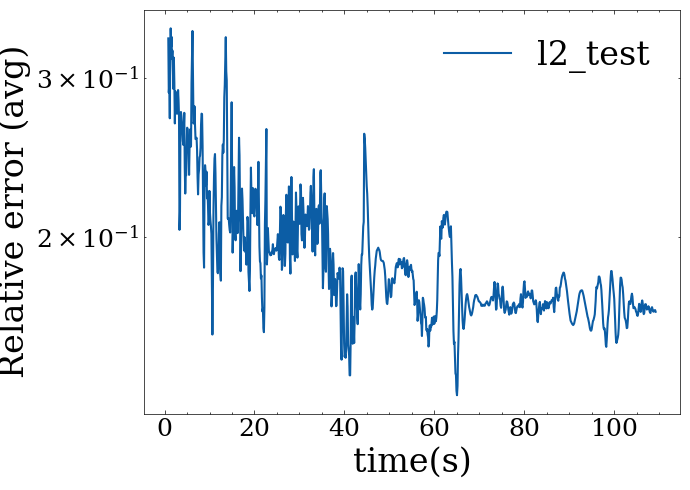

In [3]:
# #######################################
# # Load the trained model
# #######################################
from Solvers.PIDeepONet import PIDeepONet
solver = PIDeepONet.Solver(device=device, dtype=dtype)
tag = 'fdm'
model_trained = solver.loadModel(path=f'saved_models/PI{netType}_{tag}/', name=f'model_pideeponet_final')

#########################################
x_var = Variable(x_test, requires_grad=True).to(device)
try:
    a_var = model_trained['beta'](a_test.to(device))
except:
    a_var = a_test.to(device)
u_pred = model_trained['u'](x_var, a_var)
u_pred = mollifer()(u_pred, x_var).detach().cpu()
#
print('The shape of a_test:', a_test.shape)
print('The shape of u_test:', u_test.shape, 'u_pred shape', u_pred.shape)
print('The test loss (avg):', solver.getLoss(u_pred, u_test))
print('The test l2 error (avg):', solver.getError(u_pred, u_test))
inx = 0
# # ########################################
from Utils.PlotFigure import Plot
Plot.show_2d_list([grid_train]+[grid_test]*3, [a_test[inx], u_test[inx], u_pred[inx], torch.abs(u_test[inx]-u_pred[inx])], 
                  ['a_test', 'u_test', 'u_pred', 'abs u'], lb =0.)
#############################################
# show loss
loss_saved = solver.loadLoss(path=f'saved_models/PI{netType}_{tag}/', name='loss_pideeponet')
Plot.show_loss([loss_saved['loss_train'], loss_saved['loss_test'], loss_saved['loss_data'], loss_saved['loss_pde']], 
               ['loss_train', 'loss_test', 'loss_data', 'loss_pde'])
# show error
Plot.show_error([loss_saved['time']]*1, [loss_saved['error']], ['l2_test'])